In [27]:
# Project 2 - Efficient Frontier
# Author Jose Aponte
# Professor John Droescher
# Quantitative Finance - ECO 41552

Libraries

In [28]:
import math
import datetime as dt
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import scipy.optimize as sco
import matplotlib.pyplot as plt

Added Stocks

In [29]:
tickets = ['AAPL','MSFT','AMZN','TSLA','GOOGL','UNH','JNJ']

todayDate = dt.datetime.today()
sDate = dt.timedelta(2*365)
prices = yf.download(tickets, period = '2y')['Adj Close'].pct_change()
returns = prices
al = len(tickets)

[*********************100%***********************]  7 of 7 completed


In [30]:
class Tools:
    def __init__(self, returns, assets):
        self.returns = returns
        self.assets = assets
    
    def simpleComposition(self):
        self.tbl = pd.DataFrame(index=self.assets)
        self.tbl['Mean']=returns.mean()
        self.tbl['Variance']=returns.var()
        return(self.tbl.T)
    
    def correlation(self):
        self.tbl=pd.DataFrame(index=self.assets)
        self.corr = returns.corr()
        return(self.corr)

In [31]:
table = Tools(returns=returns, assets=tickets)
display(table.simpleComposition().T,table.correlation())

,Mean,Variance
AAPL,0.000702,0.000356
MSFT,0.000591,0.000351
AMZN,-0.000520,0.000651
TSLA,0.000350,0.001451
GOOGL,0.000227,0.000433
UNH,0.000665,0.000191
JNJ,0.000049,0.000099


,AAPL,AMZN,GOOGL,JNJ,MSFT,TSLA,UNH
AAPL,1.000000,0.650430,0.730224,0.294881,0.771518,0.554845,0.406450
AMZN,0.650430,1.000000,0.698991,0.172050,0.701599,0.479769,0.235037
GOOGL,0.730224,0.698991,1.000000,0.228678,0.810074,0.445185,0.313315
JNJ,0.294881,0.172050,0.228678,1.000000,0.272281,0.027843,0.492902
MSFT,0.771518,0.701599,0.810074,0.272281,1.000000,0.477424,0.395620
TSLA,0.554845,0.479769,0.445185,0.027843,0.477424,1.000000,0.170227
UNH,0.406450,0.235037,0.313315,0.492902,0.395620,0.170227,1.000000


Monte Carlo Calculation

In [33]:
def portfolioReturns(w):
    return np.sum(returns.mean()*w)*252

def portfolioVolumes(w):
    return np.sqrt(np.dot(w.T,np.dot(returns.cov()*252,w)))

returnColumn = []
volumenColumn = []
weight = []

for p in range (500000):
    weights =  np.random.random(al)
    weights /= np.sum(weights)
    weight.append(weights)
    returnColumn.append(portfolioReturns(weights))
    volumenColumn.append(portfolioVolumes(weights))

expectedReturn = np.array(returnColumn)
expectedVolumen = np.array(volumenColumn)

sharpe = (expectedReturn-0.02)/expectedVolumen

Monte Carlo Graph

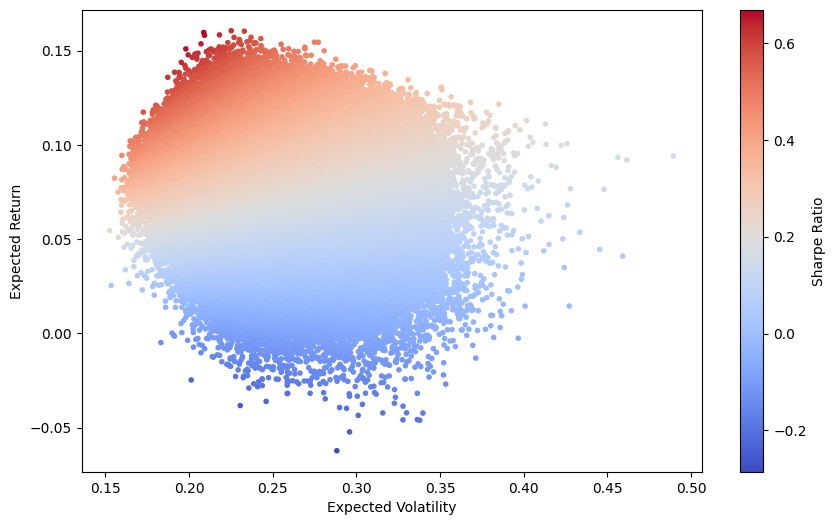

In [34]:
plt.figure(figsize=(10,6))
plt.scatter(expectedVolumen,expectedReturn, c=sharpe,
            marker = '.',cmap='coolwarm')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')

In [35]:
optimalDisplay = pd.DataFrame(columns=['Expected Return','Volatility','Optimal Sharpe Ratio'])
optimalDisplay['Expected Return'] = expectedReturn
optimalDisplay['Volatility'] = expectedVolumen
optimalDisplay['Optimal Sharpe Ratio'] = sharpe

for counter, symbol in enumerate(returns.columns.tolist()):
    optimalDisplay[symbol + " weight"] = [w[counter] for w in weight]

optimalDisplay.set_index("Optimal Sharpe Ratio", inplace=True)
portfolios = pd.DataFrame(optimalDisplay)
optimalDisplayFull = portfolios.head().T
optimalDisplayFull

Optimal Sharpe Ratio,0.091024,0.175905,0.082143,0.369137,0.175190
Expected Return,0.044151,0.075496,0.040696,0.102200,0.065409
Volatility,0.265321,0.315487,0.251946,0.222681,0.259197
AAPL weight,0.183256,0.263594,0.156442,0.244055,0.070254
AMZN weight,0.259030,0.223940,0.218516,0.117423,0.236070
GOOGL weight,0.068888,0.033462,0.052877,0.112832,0.203723
JNJ weight,0.163123,0.014874,0.270642,0.095893,0.019365
MSFT weight,0.029776,0.195235,0.127605,0.127190,0.242321
TSLA weight,0.180215,0.227013,0.162289,0.036203,0.029413
UNH weight,0.115711,0.041882,0.011629,0.266405,0.198855


In [38]:
def sharpeM(w):
    return -(portfolioReturns(w)-0.02)/portfolioVolumes(w)

constraints = ({'type': 'eq','fun':lambda x: np.sum(x)-1})
bounds = tuple((0,1) for x in range(al))
weightVolumen = np.array(al*[1. /al,])
sharpeM(weightVolumen)

-0.21927039601167156

In [42]:
sharpeOptimized = sco.minimize(sharpeM, 
                               weightVolumen, 
                               method='SLSQP', 
                               bounds= bounds,
                               constraints=constraints)
volumenOptimized = sco.minimize(portfolioVolumes, 
                                weightVolumen, 
                                method='SLSQP',
                                bounds=bounds,
                                constraints=constraints)
constraintsLinearRegresion = ({'type': 'eq', 'fun': lambda x: portfolioReturns(x)-tReturn},
                             {'type':'eq','fun': lambda x: np.sum(x)-1})
boundsLinearRegresion = tuple((0,1) for x in weights)

tReturns = np.linspace(0.05,0.2,50)
tVolatility = []

for tReturn in tReturns:
    result = sco.minimize(portfolioVolumes,
                          weightVolumen,
                          method = 'SLSQP',
                          bounds= boundsLinearRegresion,
                          constraints=constraintsLinearRegresion)
    tVolatility.append(result['fun'])
tVolatility = np.array(tVolatility)

In [43]:
optimalPortfolioReturn = portfolioReturns(sharpeOptimized['x'])
optimalPortfolioReturn.round(4)

0.1702

In [46]:
optimalPortfolioVolatilityWeight = portfolioVolumes(sharpeOptimized['x'])
optimalPortfolioVolatilityWeight.round(4)

0.2068

In [48]:
sharpeRatioMaximized = (optimalPortfolioReturn-0.02)/optimalPortfolioVolatilityWeight
sharpeRatioMaximized.round(4)

0.7264

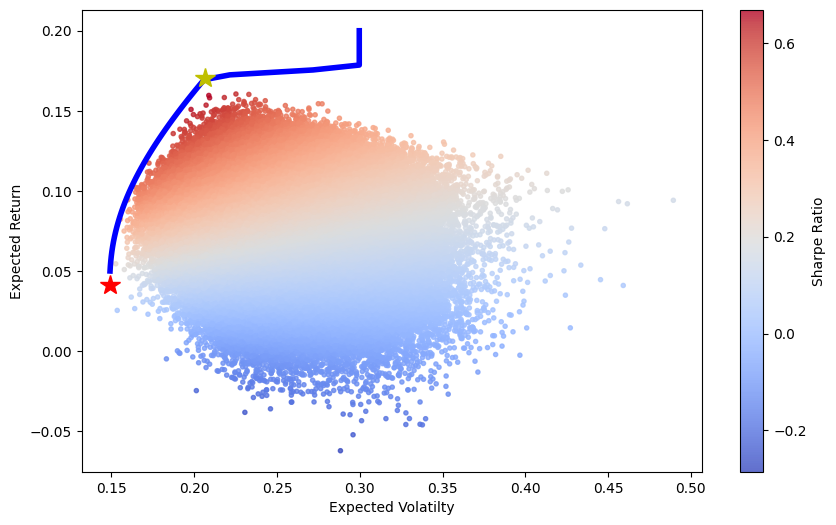

In [53]:
plt.figure(figsize=(10,6))
plt.scatter(expectedVolumen,expectedReturn, c=sharpe, marker='.',alpha=0.8, cmap='coolwarm')
plt.plot(tVolatility, tReturns, 'b',lw=4.0)

plt.plot(portfolioVolumes(sharpeOptimized['x']),
         portfolioReturns(sharpeOptimized['x']),
         'y*', markersize = 15.0)
plt.plot(portfolioVolumes(volumenOptimized['x']), 
         portfolioReturns(volumenOptimized['x']),
         'r*',markersize=15.0)
plt.xlabel('Expected Volatilty')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')